In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
from world_machine_experiments.toy1d.dimensions import Dimensions
from world_machine.train.stages import StateSaveMethod

In [2]:
metrics = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_metrics")
parameters = load_multiple_metrics("toy1d_experiment1_configuration_test", "parameters")
train_history = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_train_history")

In [3]:
list(metrics.keys()) == list(parameters.keys()), list(train_history.keys()) == list(metrics.keys())

(True, True)

In [4]:
optimizer_loss_train = get_values(train_history, ["means", "optimizer_loss_train"])
mask = np.isnan(optimizer_loss_train).sum(1) == 0

optimizer_loss_val = get_values(train_history, ["means", "optimizer_loss_val"])
mask = np.bitwise_and(mask, np.isnan(optimizer_loss_val).sum(1) == 0)

In [5]:
metric_names = ["normal", "use_state", "prediction", "prediction_shallow"]

In [6]:
print(mask.sum())
for name in metric_names:
    data = get_values(metrics, ["means",name,"state_decoded_mse"])

    data_mask = np.bitwise_not(np.isnan(data))
    data_mask = np.bitwise_and(data_mask, data<1)
    
    data_max = data[data_mask].mean() + 3*data[data_mask].std()
    
    mask = np.bitwise_and(mask, np.bitwise_not(np.isnan(data)))
    #mask = np.bitwise_and(mask, data<data_max)
    mask = np.bitwise_and(mask, data<10)

    print(mask.sum())

3263
3255
3234
3234
3180


In [7]:
uncond_diverge_prob = 1-(mask.sum()/len(mask))
uncond_diverge_prob

0.02573529411764708

In [8]:
names = np.array(list(metrics.keys()))
names_filtered = names[mask]

In [9]:
parameters_data = []

for name in parameters:
    item = parameters[name]["parameters"]
    item["name"] = name
    item["diverge"] = name not in names_filtered

    for m in metric_names:
        for criterion in ["mse", "0.1sdtw"]:
            item[f"{m}_{criterion}"] = metrics[name]["means"][m][f"state_decoded_{criterion}"]
    
    parameters_data.append(item)

In [10]:
df = pd.DataFrame(parameters_data)

In [11]:
df["SB_1"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == False)
df["SB_2"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == True)

df["SM_1"] = df["state_save_method"] == StateSaveMethod.MEAN.value
df["SM_2"] = df["check_input_masks"] == True

df["AC_1"] = pd.isnull(df["state_activation"])

df["MD_1"] = df["block_configuration"].map(lambda x : np.alltrue(x == [Dimensions.MEASUREMENT.value, Dimensions.STATE_INPUT.value]))

df["NA_1"] = df["noise_config"].map(lambda x: x is not None and "state" in x)
df["NA_2"] = df["noise_config"].map(lambda x: x is not None and "measurement" in x)

#df["ST_1"] = df["recall_stride_past"] == 1
#df["ST_2"] = df["recall_stride_past"] == 3
#df["ST_3"] = df["recall_n_past"] == 1
#df["ST_4"] = df["recall_n_past"] == 5
#df["ST_5"] = df["recall_n_future"] == 1
#df["ST_6"] = df["recall_n_future"] == 5

df["ST_1"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 1)
df["ST_2"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 5)
df["ST_3"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 1)
df["ST_4"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 5)

df["ST_5"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 1)
df["ST_6"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 5)
df["ST_7"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 1)
df["ST_8"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 5)


In [12]:
variables = ["SB_1", "SB_2", "SM_1", "SM_2", "AC_1", "MD_1", "NA_1", "NA_2", "ST_1", "ST_2", "ST_3", "ST_4", "ST_5", "ST_6", "ST_7", "ST_8"]

In [13]:
variable_count = []
for v in variables:
    variable_count.append(df[v].sum())

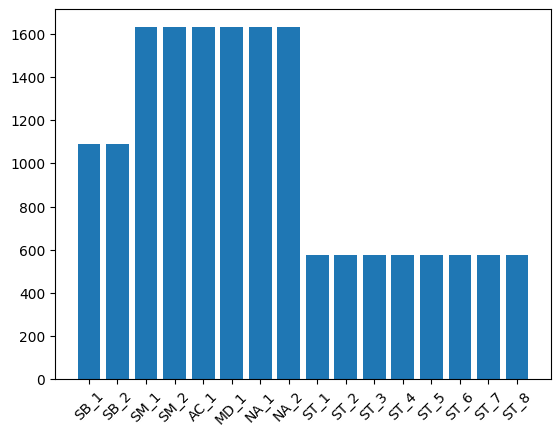

In [14]:
plt.bar(variables, variable_count)

plt.xticks(rotation=45)
plt.show()

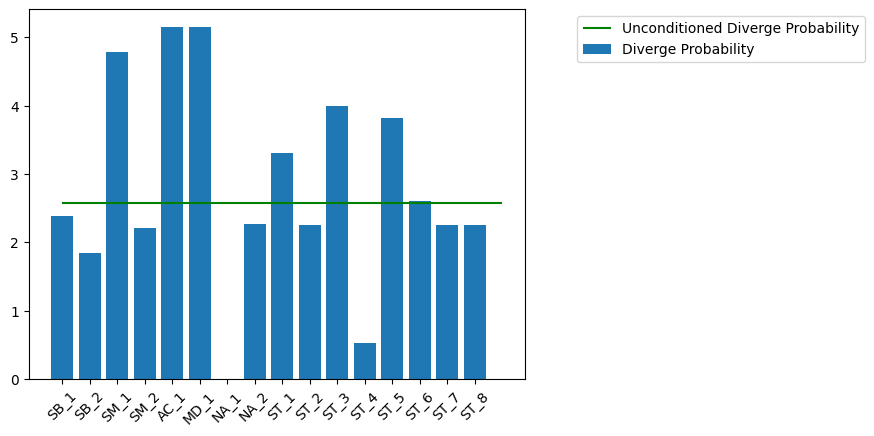

In [15]:
diverge_prob = []
for v in variables:
    prob = df[df[v]]["diverge"].sum()/len(df[df[v]])

    diverge_prob.append(prob)

diverge_prob = np.array(diverge_prob)

plt.bar(variables, 100*diverge_prob, label="Diverge Probability")

plt.hlines([100*uncond_diverge_prob], 0, len(variables), colors="green", label="Unconditioned Diverge Probability")

plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right')

plt.xticks(rotation=45)
plt.show()

In [16]:
variables_filtered = []

for i, v in enumerate(variables):
    if diverge_prob[i] < uncond_diverge_prob:
        variables_filtered.append(v)

variables_filtered

['SB_1', 'SB_2', 'SM_2', 'NA_1', 'NA_2', 'ST_2', 'ST_4', 'ST_7', 'ST_8']

In [17]:
df_filtered = df[df["diverge"] == False]
df_filtered = df_filtered.copy()

In [18]:
for m in metric_names:
        for criterion in ["mse", "0.1sdtw"]:
            c_name = f"{m}_{criterion}"
            df_filtered[f"{m}_{criterion}_normalized"] = (df_filtered[c_name] - df_filtered[c_name].min())/(df_filtered[c_name].max() - df_filtered[c_name].min())#(df_filtered[c_name] - df_filtered[c_name].mean())/df_filtered[c_name].std()

(array([3.179e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

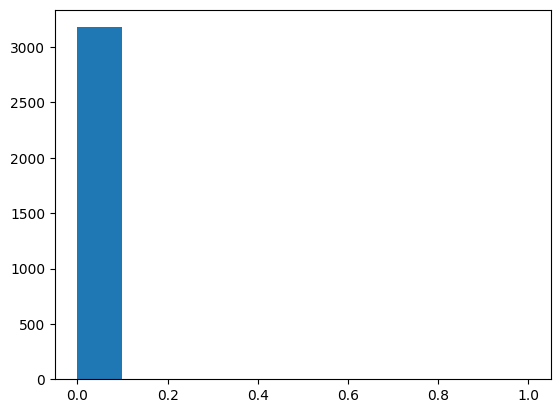

In [19]:
plt.hist(df_filtered["normal_mse_normalized"])

In [20]:
import statsmodels.formula.api as smf

In [21]:
equation = " + ".join(variables)
equation = "normal_mse ~ "+equation
equation

'normal_mse ~ SB_1 + SB_2 + SM_1 + SM_2 + AC_1 + MD_1 + NA_1 + NA_2 + ST_1 + ST_2 + ST_3 + ST_4 + ST_5 + ST_6 + ST_7 + ST_8'

In [22]:
model = smf.ols(equation, data=df_filtered).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             normal_mse   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.473
Date:                Wed, 24 Sep 2025   Prob (F-statistic):              0.100
Time:                        16:18:16   Log-Likelihood:                 4285.1
No. Observations:                3180   AIC:                            -8536.
Df Residuals:                    3163   BIC:                            -8433.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0103      0.004      2.419      0.016       0.002       0.019
SB_1[T.True]    -0.0010      0.003     -0.374      0.708      -0.006       0.004
SB_2[T.True]    -0.0019      0.003     -0.701      0.484      -0.007       0.003
SM_1[T.True]     0.0047      0.002      2.101      0.036       0.000       0.009
SM_2[T.True]    -0.0023      0.002     -1.036      0.300      -0.007       0.002
AC_1[T.True]     0.0066      0.002      2.940      0.003       0.002       0.011
MD_1[T.True]    -0.0022      0.002     -0.985      0.325      -0.007       0.002
NA_1[T.True]    -0.0012      0.002     -0.539      0.590      -0.006       0.003
NA_2[T.True]    -0.0012      0.002     -0.516      0.606      -0.006       0.003
ST_1[T.True]    -0.0015      0.004     -0.417      0.677      -0.009       0.006
ST_2[T.True]    -0.0023      0.004     -0.628      0.530      -0.009       0.005
ST_3[T.True]    -0.0048      0.004     -1.339      0.181      -0.012       0.002
ST_4[T.True]    -0.0060      0.004     -1.694      0.090      -0.013       0.001
ST_5[T.True]    -0.0019      0.004     -0.534      0.594      -0.009       0.005
ST_6[T.True]    -0.0015      0.004     -0.410      0.682      -0.009       0.006
ST_7[T.True]     0.0068      0.004      1.908      0.056      -0.000       0.014
ST_8[T.True]     0.0013      0.004      0.372      0.710      -0.006       0.008
==============================================================================
Omnibus:                    10461.722   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1272801240.485
Skew:                          55.341   Prob(JB):                         0.00
Kurtosis:                    3100.385   Cond. No.                         9.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

- P>|t| alto -> coeficiente não é medido pelo modelo (chance da variável dependente não ser afetada por esta variável é alta)

- Prob(Ommibus) e Prob(JB) baixas -> resíduos não normalmente distribuídos -> regressão de má qualidade
- Cond. No. alto -> multicolinariedade -> variáveis não independentes

In [24]:
equation_filtered = " + ".join(variables_filtered)
equation_filtered = "normal_mse_normalized ~ "+equation_filtered
equation_filtered

'normal_mse_normalized ~ SB_1 + SB_2 + SM_2 + NA_1 + NA_2 + ST_2 + ST_4 + ST_7 + ST_8'

In [25]:
model = smf.ols(equation_filtered, data=df_filtered).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     normal_mse_normalized   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.8435
Date:                   Wed, 24 Sep 2025   Prob (F-statistic):              0.576
Time:                           16:18:16   Log-Likelihood:                 8303.8
No. Observations:                   3180   AIC:                        -1.659e+04
Df Residuals:                       3170   BIC:                        -1.653e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0022      0.001      2.508      0.012       0.000       0.004
SB_1[T.True]    -0.0003      0.001     -0.358      0.720      -0.002       0.001
SB_2[T.True]    -0.0005      0.001     -0.678      0.498      -0.002       0.001
SM_2[T.True]    -0.0006      0.001     -1.021      0.307      -0.002       0.001
NA_1[T.True]    -0.0003      0.001     -0.445      0.656      -0.002       0.001
NA_2[T.True]    -0.0003      0.001     -0.506      0.613      -0.002       0.001
ST_2[T.True]    -0.0003      0.001     -0.334      0.739      -0.002       0.001
ST_4[T.True]    -0.0010      0.001     -1.158      0.247      -0.003       0.001
ST_7[T.True]     0.0019      0.001      2.118      0.034       0.000       0.004
ST_8[T.True]     0.0004      0.001      0.397      0.692      -0.001       0.002
==============================================================================
Omnibus:                    10463.550   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1274406659.878
Skew:                          55.369   Prob(JB):                         0.00
Kurtosis:                    3102.339   Cond. No.                         5.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
df_filtered["normal_mse"].mean()

0.00960993807054119

In [27]:
equation_filtered_ps = " + ".join(variables_filtered)
equation_filtered_ps = "prediction_shallow_mse_normalized ~ "+equation_filtered_ps
equation_filtered_ps

model = smf.ols(equation_filtered_ps, data=df_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     prediction_shallow_mse_normalized   R-squared:                       0.091
Model:                                           OLS   Adj. R-squared:                  0.089
Method:                                Least Squares   F-statistic:                     35.44
Date:                               Wed, 24 Sep 2025   Prob (F-statistic):           3.28e-60
Time:                                       16:18:16   Log-Likelihood:                 6365.6
No. Observations:                               3180   AIC:                        -1.271e+04
Df Residuals:                                   3170   BIC:                        -1.265e+04
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0530      0.002     33.541      0.000       0.050       0.056
SB_1[T.True]    -0.0020      0.001     -1.393      0.164      -0.005       0.001
SB_2[T.True]    -0.0096      0.001     -6.778      0.000      -0.012      -0.007
SM_2[T.True]    -0.0022      0.001     -1.936      0.053      -0.005    2.89e-05
NA_1[T.True]     0.0173      0.001     14.934      0.000       0.015       0.020
NA_2[T.True]    -0.0056      0.001     -4.812      0.000      -0.008      -0.003
ST_2[T.True]     0.0054      0.002      3.292      0.001       0.002       0.009
ST_4[T.True]    -0.0027      0.002     -1.700      0.089      -0.006       0.000
ST_7[T.True]     0.0021      0.002      1.271      0.204      -0.001       0.005
ST_8[T.True]     0.0023      0.002      1.384      0.166      -0.001       0.006
==============================================================================
Omnibus:                     4691.910   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6483368.758
Skew:                           8.286   Prob(JB):                         0.00
Kurtosis:                     223.582   Cond. No.                         5.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
df_filtered["prediction_shallow_0.1sdtw"]

0       2.236013
1       1.017790
2       1.139297
3       0.803979
4       0.825258
          ...   
3259    1.458012
3260    2.238296
3261    0.922440
3262    0.981168
3263    0.981895
Name: prediction_shallow_0.1sdtw, Length: 3180, dtype: float64

In [29]:
equation_filtered_ps = " + ".join(variables_filtered)
equation_filtered_ps = "Q('prediction_shallow_0.1sdtw') ~ "+equation_filtered_ps
equation_filtered_ps

model = smf.ols(equation_filtered_ps, data=df_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Q('prediction_shallow_0.1sdtw')   R-squared:                       0.204
Model:                                         OLS   Adj. R-squared:                  0.201
Method:                              Least Squares   F-statistic:                     90.03
Date:                             Wed, 24 Sep 2025   Prob (F-statistic):          1.09e-149
Time:                                     16:18:16   Log-Likelihood:                -2587.9
No. Observations:                             3180   AIC:                             5196.
Df Residuals:                                 3170   BIC:                             5256.
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4066      0.026     53.262      0.000       1.355       1.458
SB_1[T.True]    -0.2905      0.024    -12.206      0.000      -0.337      -0.244
SB_2[T.True]    -0.4041      0.024    -17.001      0.000      -0.451      -0.357
SM_2[T.True]    -0.0560      0.019     -2.886      0.004      -0.094      -0.018
NA_1[T.True]     0.4106      0.019     21.160      0.000       0.373       0.449
NA_2[T.True]    -0.0786      0.019     -4.052      0.000      -0.117      -0.041
ST_2[T.True]     0.0680      0.027      2.494      0.013       0.015       0.121
ST_4[T.True]    -0.0949      0.027     -3.553      0.000      -0.147      -0.043
ST_7[T.True]     0.0185      0.028      0.668      0.504      -0.036       0.073
ST_8[T.True]     0.0037      0.028      0.135      0.892      -0.050       0.058
==============================================================================
Omnibus:                     3329.055   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1002862.305
Skew:                           4.587   Prob(JB):                         0.00
Kurtosis:                      89.514   Cond. No.                         5.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
disjunt_groups = [{"ST_1", "ST_2", "ST_3", "ST_4"}, 
                  {"ST_5", "ST_6", "ST_7", "ST_8"}, 
                  {"ST_1", "ST_2", "ST_7", "ST_8"},
                  {"ST_3", "ST_4", "ST_5", "ST_6"},
                  {"SB_1", "SB_2"},
                  ]

def get_equation(variables, target, include_joint=False):
    
    equation = " + ".join(variables)

    if include_joint:
        for i in range(len(variables)):
            for j in range(i+1, len(variables)):
                v1 = variables[i]
                v2 = variables[j]

                disjunt = False
                for dg in disjunt_groups:
                    if v1 in dg and v2 in dg:
                        disjunt = True

                if not disjunt:
                    equation += f"+ {v1}:{v2}"
            

    equation = f"{target} ~ {equation}"
    
    return equation


In [95]:
def get_coef_matrix(model, variables):
    coef = np.zeros((len(variables), len(variables)))

    if isinstance(model.params, np.ndarray):
        param_names = model.model.exog_names
    else:
        param_names = model.params.index


    for i, v1 in enumerate(variables):
        for j, v2 in enumerate(variables):

            for key_index, key in enumerate(param_names):
                if v1 in key and v2 in key:
                    if isinstance(model.params, np.ndarray):
                        coef[i,j] = model.params[key_index]
                    else:
                        coef[i,j] = model.params[key]
                    break
    
    return coef
    

In [88]:
def plot_coef_matrix(coef, variables, ax=None):
    v_max = np.max(np.abs(coef))

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(coef, cmap="bwr", vmin=-v_max, vmax=v_max)

    ax.set_xticks(np.arange(0, len(variables), 1), variables, rotation=45)
    ax.set_yticks(np.arange(0, len(variables), 1), variables, rotation=45)

    ax.get_figure().colorbar(im)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     prediction_shallow_mse   R-squared:                       0.113
Model:                                OLS   Adj. R-squared:                  0.102
Method:                     Least Squares   F-statistic:                     10.02
Date:                    Wed, 24 Sep 2025   Prob (F-statistic):           6.64e-57
Time:                            16:33:10   Log-Likelihood:                 5040.0
No. Observations:                    3180   AIC:                            -9998.
Df Residuals:                        3139   BIC:                            -9749.
Df Model:                              40                                         
Covariance Type:                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2003      0.004     46.533      0.000       0.192       0.209
SB_1[T.True]                 -0.0097      0.005     -1.933      0.053      -0.020       0.000
SB_2[T.True]                 -0.0142      0.005     -2.820      0.005      -0.024      -0.004
SM_2[T.True]                 -0.0009      0.004     -0.212      0.832      -0.010       0.008
NA_1[T.True]                  0.0197      0.004      4.425      0.000       0.011       0.028
NA_2[T.True]                 -0.0110      0.004     -2.455      0.014      -0.020      -0.002
ST_2[T.True]                  0.0155      0.006      2.489      0.013       0.003       0.028
ST_4[T.True]                  0.0120      0.007      1.792      0.073      -0.001       0.025
ST_7[T.True]                  0.0196      0.006      3.053      0.002       0.007       0.032
ST_8[T.True]                 -0.0021      0.006     -0.327      0.744      -0.015       0.011
SB_1[T.True]:SM_2[T.True]     0.0007      0.004      0.163      0.871      -0.008       0.009
SB_1[T.True]:NA_1[T.True]     0.0227      0.004      5.222      0.000       0.014       0.031
SB_1[T.True]:NA_2[T.True]     0.0025      0.004      0.577      0.564      -0.006       0.011
SB_1[T.True]:ST_2[T.True]    -0.0075      0.006     -1.227      0.220      -0.019       0.004
SB_1[T.True]:ST_4[T.True]    -0.0188      0.006     -3.151      0.002      -0.031      -0.007
SB_1[T.True]:ST_7[T.True]    -0.0117      0.006     -1.885      0.060      -0.024       0.000
SB_1[T.True]:ST_8[T.True]     0.0014      0.006      0.219      0.827      -0.011       0.014
SB_2[T.True]:SM_2[T.True]     0.0018      0.004      0.411      0.681      -0.007       0.010
SB_2[T.True]:NA_1[T.True]     0.0025      0.004      0.572      0.568      -0.006       0.011
SB_2[T.True]:NA_2[T.True]     0.0061      0.004      1.405      0.160      -0.002       0.015
SB_2[T.True]:ST_2[T.True]    -0.0077      0.006     -1.256      0.209      -0.020       0.004
SB_2[T.True]:ST_4[T.True]    -0.0177      0.006     -2.967      0.003      -0.029      -0.006
SB_2[T.True]:ST_7[T.True]    -0.0105      0.006     -1.702      0.089      -0.023       0.002
SB_2[T.True]:ST_8[T.True]     0.0031      0.006      0.497      0.619      -0.009       0.015
SM_2[T.True]:NA_1[T.True]    -0.0045      0.004     -1.267      0.205      -0.011       0.002
SM_2[T.True]:NA_2[T.True]    -0.0002      0.004     -0.062      0.950      -0.007       0.007
SM_2[T.True]:ST_2[T.True]    -0.0026      0.005     -0.529      0.597      -0.012       0.007
SM_2[T.True]:ST_4[T.True]     0.0064      0.005      1.306      0.192      -0.003       0.016
SM_2[T.True]:ST_7[T.True]    -0.0063      0.005     -1.250      0.211      -0.016       0.004
SM_2[T.True]:ST_8[T.True]    -0

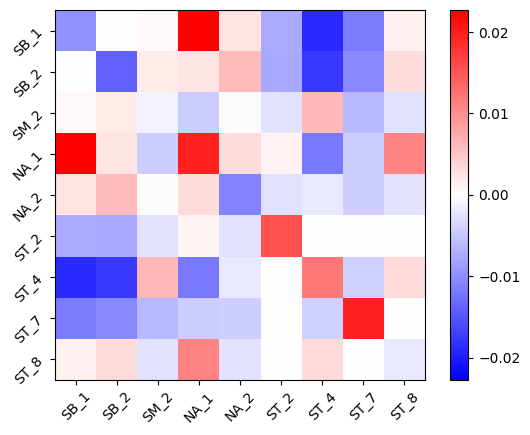

In [89]:
equation = get_equation(variables_filtered, "prediction_shallow_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)
plot_coef_matrix(coef, variables_filtered)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             normal_mse   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.212
Date:                Wed, 24 Sep 2025   Prob (F-statistic):              0.170
Time:                        16:18:16   Log-Likelihood:                 4297.7
No. Observations:                3180   AIC:                            -8513.
Df Residuals:                    3139   BIC:                            -8265.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0195      0.005      3.593      0.000       0.009       0.030
SB_1[T.True]                 -0.0114      0.006     -1.794      0.073      -0.024       0.001
SB_2[T.True]                 -0.0110      0.006     -1.726      0.084      -0.023       0.001
SM_2[T.True]                 -0.0098      0.006     -1.730      0.084      -0.021       0.001
NA_1[T.True]                 -0.0106      0.006     -1.877      0.061      -0.022       0.000
NA_2[T.True]                 -0.0083      0.006     -1.461      0.144      -0.019       0.003
ST_2[T.True]                 -0.0027      0.008     -0.349      0.727      -0.018       0.013
ST_4[T.True]                 -0.0155      0.008     -1.832      0.067      -0.032       0.001
ST_7[T.True]                  0.0441      0.008      5.448      0.000       0.028       0.060
ST_8[T.True]                  0.0023      0.008      0.286      0.775      -0.014       0.018
SB_1[T.True]:SM_2[T.True]     0.0073      0.005      1.339      0.181      -0.003       0.018
SB_1[T.True]:NA_1[T.True]     0.0103      0.005      1.876      0.061      -0.000       0.021
SB_1[T.True]:NA_2[T.True]     0.0068      0.005      1.232      0.218      -0.004       0.018
SB_1[T.True]:ST_2[T.True]     0.0016      0.008      0.204      0.838      -0.014       0.017
SB_1[T.True]:ST_4[T.True]     0.0090      0.008      1.194      0.232      -0.006       0.024
SB_1[T.True]:ST_7[T.True]    -0.0207      0.008     -2.654      0.008      -0.036      -0.005
SB_1[T.True]:ST_8[T.True]    -0.0012      0.008     -0.154      0.878      -0.017       0.014
SB_2[T.True]:SM_2[T.True]     0.0072      0.005      1.319      0.187      -0.004       0.018
SB_2[T.True]:NA_1[T.True]     0.0080      0.005      1.459      0.145      -0.003       0.019
SB_2[T.True]:NA_2[T.True]     0.0065      0.005      1.178      0.239      -0.004       0.017
SB_2[T.True]:ST_2[T.True]     0.0016      0.008      0.207      0.836      -0.014       0.017
SB_2[T.True]:ST_4[T.True]     0.0092      0.008      1.218      0.223      -0.006       0.024
SB_2[T.True]:ST_7[T.True]    -0.0205      0.008     -2.623      0.009      -0.036      -0.005
SB_2[T.True]:ST_8[T.True]    -0.0012      0.008     -0.154      0.878      -0.017       0.014
SM_2[T.True]:NA_1[T.True]     0.0043      0.004      0.971      0.332      -0.004       0.013
SM_2[T.True]:NA_2[T.True]     0.0040      0.004      0.893      0.372      -0.005       0.013
SM_2[T.True]:ST_2[T.True]     0.0002      0.006      0.040      0.968      -0.012       0.013
SM_2[T.True]:ST_4[T.True]     0.0049      0.006      0.801      0.423      -0.007       0.017
SM_2[T.True]:ST_7[T.True]    -0.0135      0.006     -2.114      0.035      -0.026      -0.001
SM_2[T.True]:ST_8[T.True]    -0.0008      0.006     -0.123      0.902      

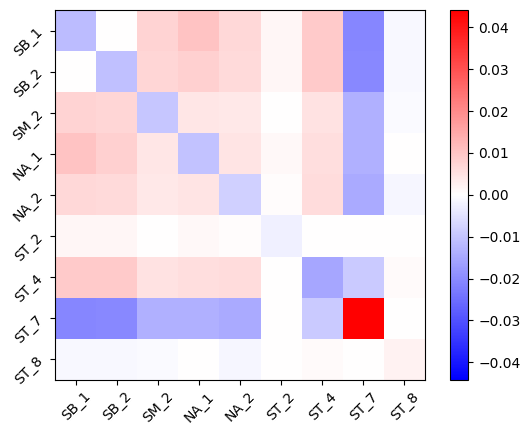

In [34]:
equation = get_equation(variables_filtered, "normal_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

plot_coef_matrix(coef, variables_filtered)

model.summary()

Text(0.5, 0.98, 'Normal MSE')

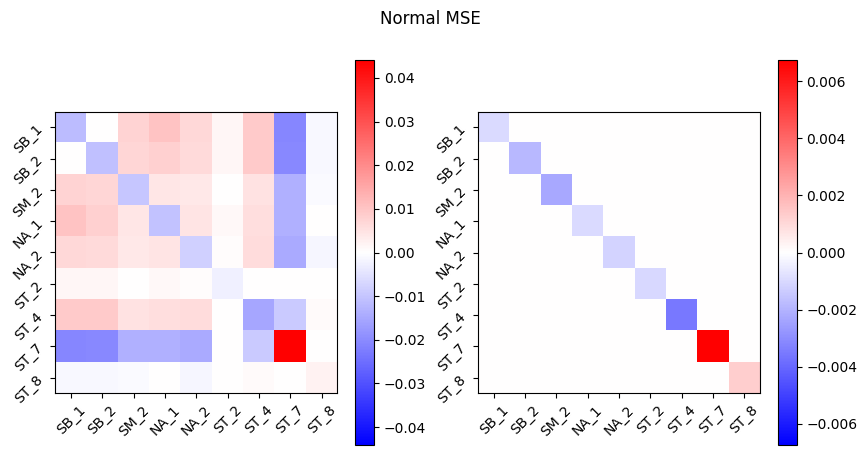

In [35]:
equation = get_equation(variables_filtered, "normal_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

equation = get_equation(variables_filtered, "normal_mse", False)
model = smf.ols(equation, data=df_filtered).fit()
coef2 = get_coef_matrix(model, variables_filtered)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_coef_matrix(coef, variables_filtered, ax[0])
plot_coef_matrix(coef2, variables_filtered, ax[1])

fig.suptitle("Normal MSE")


Text(0.5, 0.98, 'Prediction Shallow MSE')

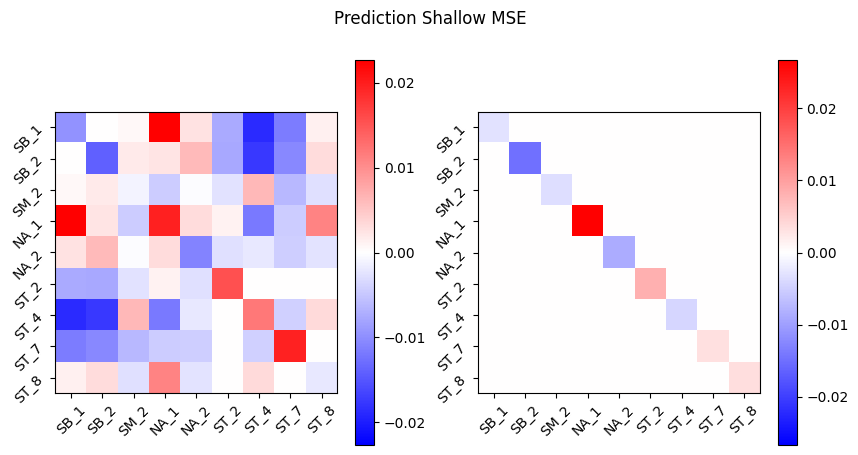

In [59]:
equation = get_equation(variables_filtered, "prediction_shallow_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

equation = get_equation(variables_filtered, "prediction_shallow_mse", False)
model2 = smf.ols(equation, data=df_filtered).fit()
coef2 = get_coef_matrix(model2, variables_filtered)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_coef_matrix(coef, variables_filtered, ax[0])
plot_coef_matrix(coef2, variables_filtered, ax[1])

fig.suptitle("Prediction Shallow MSE")


In [60]:
np.sum(coef, axis=1)

array([-0.02045512, -0.03663023, -0.00855922,  0.03947522, -0.01086287,
       -0.00382886, -0.03281306, -0.02180575,  0.01125265])

In [61]:
coef2.diagonal()

array([-0.00304804, -0.01481327, -0.00345239,  0.0266445 , -0.00858211,
        0.00825373, -0.00417386,  0.00322599,  0.00351754])

Text(0.5, 1.0, 'Prediction Shallow')

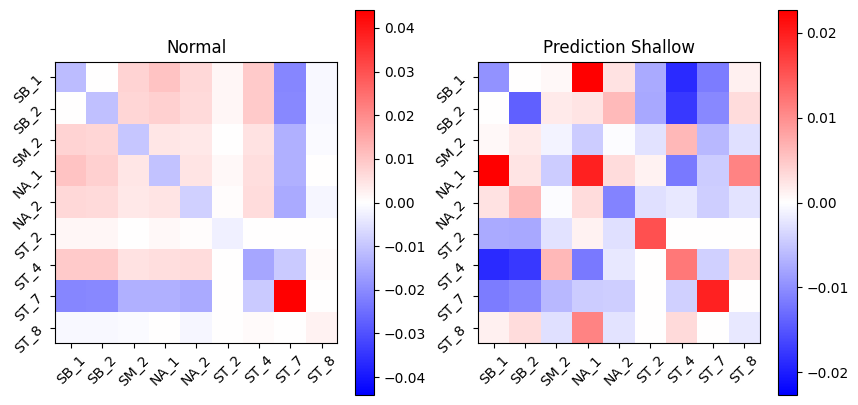

In [40]:
equation = get_equation(variables_filtered, "normal_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

equation = get_equation(variables_filtered, "prediction_shallow_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef2 = get_coef_matrix(model, variables_filtered)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_coef_matrix(coef, variables_filtered, ax[0])
plot_coef_matrix(coef2, variables_filtered, ax[1])

ax[0].set_title("Normal")
ax[1].set_title("Prediction Shallow")


Text(0.5, 1.0, 'Regularized+Single')

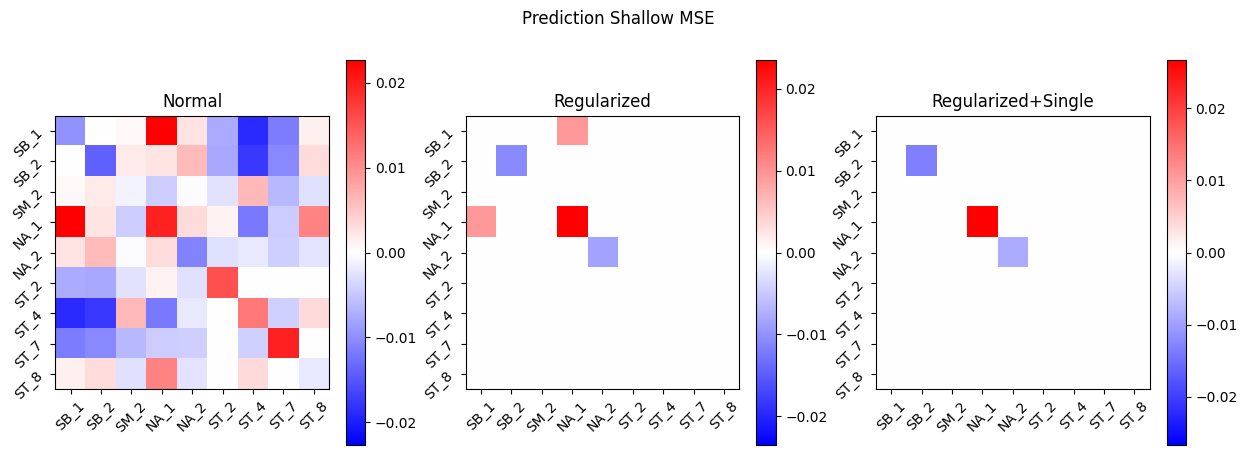

In [108]:
equation = get_equation(variables_filtered, "prediction_shallow_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

equation = get_equation(variables_filtered, "prediction_shallow_mse", True)
model2 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef2 = get_coef_matrix(model2, variables_filtered)


equation = get_equation(variables_filtered, "prediction_shallow_mse", False)
model3 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef3 = get_coef_matrix(model3, variables_filtered)


fig, ax = plt.subplots(1, 3, figsize=(15,5))

plot_coef_matrix(coef, variables_filtered, ax[0])
plot_coef_matrix(coef2, variables_filtered, ax[1])
plot_coef_matrix(coef3, variables_filtered, ax[2])

fig.suptitle("Prediction Shallow MSE")
ax[0].set_title("Normal")
ax[1].set_title("Regularized")
ax[2].set_title("Regularized+Single")

Text(0.5, 1.0, 'Regularized+Single')

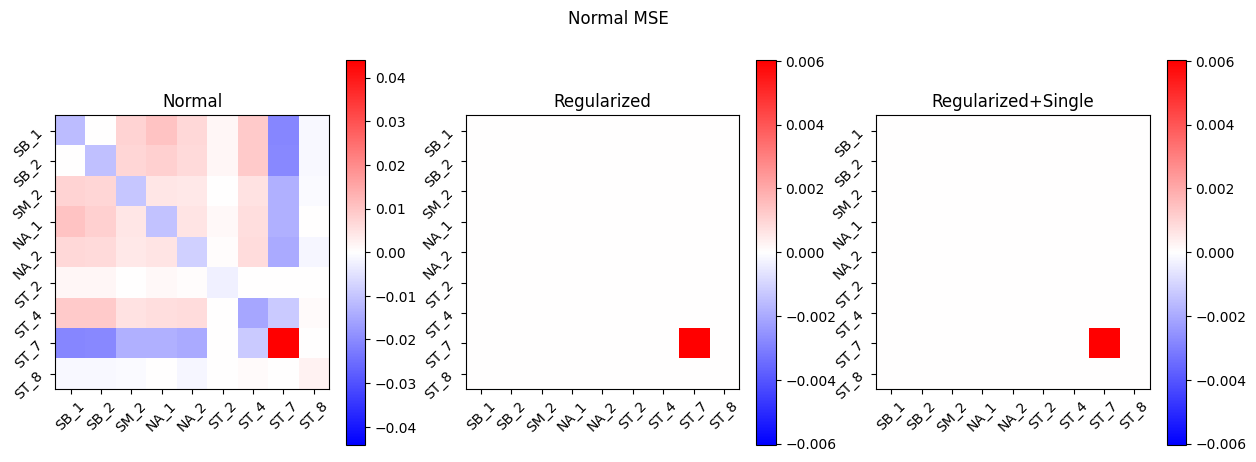

In [ ]:
equation = get_equation(variables_filtered, "normal_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables_filtered)

equation = get_equation(variables_filtered, "normal_mse", True)
model2 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef2 = get_coef_matrix(model2, variables_filtered)

equation = get_equation(variables_filtered, "normal_mse", False)
model3 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef3 = get_coef_matrix(model3, variables_filtered)


fig, ax = plt.subplots(1, 3, figsize=(15,5))

plot_coef_matrix(coef, variables_filtered, ax[0])
plot_coef_matrix(coef2, variables_filtered, ax[1])
plot_coef_matrix(coef3, variables_filtered, ax[2])

fig.suptitle("Normal MSE")
ax[0].set_title("Normal")
ax[1].set_title("Regularized")
ax[2].set_title("Regularized+Single")

Text(0.5, 1.0, 'Regularized+Single')

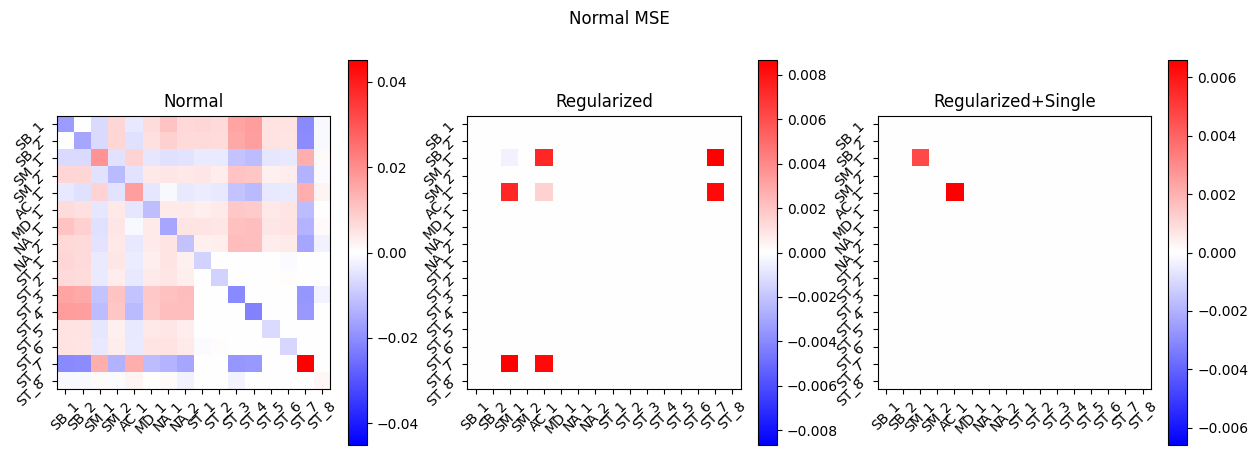

In [111]:
equation = get_equation(variables, "normal_mse", True)
model = smf.ols(equation, data=df_filtered).fit()
coef = get_coef_matrix(model, variables)

equation = get_equation(variables, "normal_mse", True)
model2 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef2 = get_coef_matrix(model2, variables)

equation = get_equation(variables, "normal_mse", False)
model3 = smf.ols(equation, data=df_filtered).fit_regularized(alpha=1e-3, refit=True)
coef3 = get_coef_matrix(model3, variables)


fig, ax = plt.subplots(1, 3, figsize=(15,5))

plot_coef_matrix(coef, variables, ax[0])
plot_coef_matrix(coef2, variables, ax[1])
plot_coef_matrix(coef3, variables, ax[2])

fig.suptitle("Normal MSE")
ax[0].set_title("Normal")
ax[1].set_title("Regularized")
ax[2].set_title("Regularized+Single")